# Depth of File
**Author:** Marang Mutloatse

**Description:** This script check the depth of file based on the target variable i.e what is the LTFU rate for different segments of the poulation in the high, mid and low risk groups

**Version:** 0.0.1

**Status:** Development

## Import Libraries

In [2]:
import os
user_dev_path = os.path.dirname(os.getcwd())
# get parent path for package
package_path = os.path.dirname(user_dev_path)
import sys
import pandas as pd
import yaml
import datetime as dt
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
sys.path.insert(0,package_path + '/src/')
from hiv_support_package import visit_features,helper_functions,evaluation_metrics,plist_manager
from sklearn.impute import SimpleImputer
from datetime import timedelta, date
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score,f1_score, roc_auc_score, matthews_corrcoef,roc_curve,classification_report,confusion_matrix
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold,TimeSeriesSplit,GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from numpy import mean
from numpy import std
import sklearn

plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Working Functions


In [2]:
def classification():
    roc_auc = []
    precision = []
    recall = []
    f1 =[]
    gini_coef = []
    ks_stat = []
    mcc = []
    sensitivity = []
    specificity = []
    for i in range(len(algorithms)):
        algorithms[i].fit(X_train, y_train) 
    for i in range(len(algorithms)):
        roc_auc.append(roc_auc_score(y_test, algorithms[i].predict_proba(X_test)[:,1]))
        precision.append(precision_score(y_test, algorithms[i].predict(X_test), average = 'macro'))
        recall.append(recall_score(y_test, algorithms[i].predict(X_test), average = 'macro'))
        f1.append(f1_score(y_test, algorithms[i].predict(X_test), average = 'macro'))
        gini_coef.append(evaluation_metrics.calculate_gini_score(y_test, algorithms[i].predict_proba(X_test)[:,1]))
        ks_stat.append(evaluation_metrics.calculate_ks(y_test,algorithms[i].predict_proba(X_test)[:,1]))
        mcc.append(matthews_corrcoef(y_test, algorithms[i].predict(X_test)))
        (tn, fp), (fn, tp) = confusion_matrix(y_test, algorithms[i].predict(X_test))
        specificity.append(round(tn/(tn+fp), 3))
        sensitivity.append(round(tp/(tp+fn),3))

    
    df_metrics = pd.DataFrame(columns = ['ROC_AUC','F1','Precision', 'Recall','MCC','GINI','KS'], index = algo_names)
    df_metrics['ROC_AUC'] = roc_auc
    df_metrics['F1'] = f1
    df_metrics['Precision'] = precision
    df_metrics['Recall'] = recall
    df_metrics['MCC'] = mcc
    df_metrics['GINI'] = gini_coef
    df_metrics['KS'] = ks_stat
    df_metrics['Sensitivity'] = sensitivity
    df_metrics['Specificity'] = specificity

    return df_metrics

Classification_results = {}
Final_Scores = pd.DataFrame(columns=['Model', 'Train_ROC','Test_ROC'])

def cv_classification(X_train, X_test, y_train, y_test, estimator, verbose=False ,Report=False):
    train_scores=[]
    test_scores=[]

    estimator.fit(X_train, y_train)
    #cv = TimeSeriesSplit(n_splits=4)
    cv = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
    train_metric = cross_val_score(estimator, X_train, y_train, scoring='roc_auc', cv=cv)
    train_scores.append(np.mean(train_metric))
    if verbose is True:
        print('Avg roc_auc: {:.3f} +/-{:.3f}'.format(np.mean(train_metric), np.std(train_metric)))
      
    y_pred = estimator.predict_proba(X_test)[:,1]
    test_score = estimator.score(X_test, y_test)
    test_scores.append(test_score)
   
    if verbose is True:
        print('roc_auc on test: {:.3f}'.format(test_score))
    if Report is True:
        print(classification_report(y_test,y_pred))
    
    return train_scores, test_scores

def plot_compare(d, label, new_training_score, new_test_score, ymin=0.50, ymax=0.99):
    d.update({label: [np.median(new_training_score),
                      np.median(new_test_score)]})
    plt.figure(figsize=(8,10))
    pd.DataFrame(d).set_index([pd.Index(['Training', 'Test'])]).plot.bar()
    plt.ylim(ymin, ymax)
    plt.savefig(f"../Figures/Predict_ROC_AUC_{label}.png",transparent=True,bbox_inches="tight")
    plt.show()

def features_importance(tree, X):
    importances = tree.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(20, 10))
    plt.title("Feature importances")
    plt.barh(range(X_train.shape[1]), importances[indices],
             color="r", align="center")
    index_names = [list(X_train)[i] for i in indices]
    plt.yticks(range(X_train.shape[1]), index_names)
    plt.ylim([-1, X_train.shape[1]])
    plt.xlim([0.0, 0.8])
    plt.savefig(f"../Figures/featureImportance_{tree}.png",transparent=True,bbox_inches="tight")
    plt.show()

## Loading Data

In [3]:
try: 
    with open (user_dev_path + '/' + 'config_LTFU.yaml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print(f'Error reading the config file, {e}')

In [4]:
input_root = config['rise_files']['raw_data_path']
uv_file = config['output_files']['unified_view_file']
uv_input = input_root + uv_file
print(uv_input)

/data/rise_data/unified_view.csv


In [5]:
%%time
df = pd.read_csv(uv_input,low_memory=False)

CPU times: user 23.2 s, sys: 2.16 s, total: 25.4 s
Wall time: 26.3 s


## Initial Checks

In [6]:
helper_functions.print_num_rows_cols(df, 'Unified View')

Unified View data has 235 columns and 606203 rows.


In [7]:
helper_functions.check_null_values(df)

There are 48 columns that have missing values


Missing Values  \
P_DATE_REGISTRATION                                         606203   
L_EF_YEAR_DATE_REPORTED                                     351811   
L_LABORATORY_ID                                             351811   
L_EF_IS_WEEKEND_DATE_REPORTED                               351811   
L_EF_DAY_OF_WEEK_DATE_REPORTED                              351811   
L_EF_DAY_OF_MONTH_DATE_REPORTED                             351811   
L_EF_IS_END_OF_MONTH_DATE_REPORTED                          351811   
L_EF_IS_START_OF_MONTH_DATE_REPORTED                        351811   
L_EF_MONTH_DATE_REPORTED                                    351811   
L_EF_IS_START_OF_QUARTER_DATE_REPORTED                      351811   
L_COMMENT                                                   351811   
L_RESULTAB                                                  351811   
L_DATE_COLLECTED                                            351811   
L_DATE_REPORTED                                             351811   
L_FACILITY_ID                                               351811   
L_PATIENT_ID                                                351811   
L_EF_IS_END_OF_QUARTER_DATE_REPORTED                        351811   
L_EF_QUARTER_DATE_REPORTED                                  351811   
L_EF_SEASON_DATE_REPORTED                                   351811   
L_T_VL_UNDETECT_40                                          351811   
L_T_RISE_VL_CATEGORIZATION                                  351811   
L_T_VL_SUPP_1000                                            351811   
L_T_VL_SUPP_400                                             351811   
L_T_VL_UNSUPP_1000                                          351811   
L_T_VL_UNSUPP_400                                           351811   
L_EF_VL_COUNT                                               351811   
L_EF_LAST_VL_VALUE                                          351811   
L_EF_VL_VAL                                                 351811   
L_EF_VL_CUMMAX                                              351811   
L_EF_VL_CUMMIN                                              351811   
L_EF_WEEK_OF_MONTH_DATE_REPORTED                            351811   
P_DATE_CONFIRMED_HIV                                        139061   
V_EF_NEXT_ACTUAL_VISIT_DATE                                  78945   
V_EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_V...           78945   
V_T_DAYS_UNTIL_ACTUAL_VISIT_DATE                             78945   
V_EF_DAYS_BETWEEN_MEDS_CONSUMED_AND_ACTUAL_VISI...           78945   
P_CBO_ID                                                     11635   
P_DATE_NEXT_CLINIC                                           10822   
P_DATE_STARTED                                                3110   
P_DATE_LAST_CLINIC                                             903   
P_DATE_CURRENT_STATUS                                          607   
P_DATE_NEXT_REFILL                                             278   
P_REGIMENTYPE                                                  257   
P_DATE_LAST_REFILL                                             252   
P_REGIMEN                                                      252   
S_CURRENT_STATUS                                               144   
P_LAST_CLINIC_STAGE                                              1   
P_CURRENT_STATUS                                                 1   

                                                    % of Total Values  
P_DATE_REGISTRATION                                             100.0  
L_EF_YEAR_DATE_REPORTED                                          58.0  
L_LABORATORY_ID                                                  58.0  
L_EF_IS_WEEKEND_DATE_REPORTED                                    58.0  
L_EF_DAY_OF_WEEK_DATE_REPORTED                                   58.0  
L_EF_DAY_OF_MONTH_DATE_REPORTED                                  58.0  
L_EF_IS_END_OF_MONTH_DATE_REPORTED                               58.0  
L_EF_IS_START_OF_MONTH_DATE_REPORTED         

In [8]:
drop_some_cols = [
    "P_DATE_NEXT_CLINIC",
    "P_DATE_LAST_CLINIC",
    "V_PHARMACY_ID",
    "L_T_VL_SUPP_400",
    "L_T_VL_UNSUPP_400",
    "P_REGIMENTYPE",
    "L_LABORATORY_ID",
    "L_FACILITY_ID",
    "L_DATE_REPORTED",
    "L_DATE_COLLECTED",
    "P_PATIENT_ID",
    "P_DATE_NEXT_REFILL",
    "L_PATIENT_ID",
    "L_T_VL_UNSUPP_1000",
    "P_DATE_LAST_REFILL",
    "P_LAST_VIRAL_LOAD",
    "P_LAST_CD4",
    "P_LAST_CD4P",
    "P_REGIMEN",
    "P_DATE_CONFIRMED_HIV",
    "P_DATE_STARTED",
    "P_DATE_REGISTRATION",
    "P_DATE_BIRTH",
    "L_T_VL_UNDETECT_40"
]
df.drop(columns=drop_some_cols,inplace=True)

In [9]:
df = df.sort_values(by=['V_PATIENT_ID','V_DATE_VISIT'])

### Inclusion Criteria

In [10]:
# Filter date
df = df.loc[(df['EF_START_DATE_TREATMENT'] >= '2017-01-01 00:00:00') & (df['V_DATE_VISIT'] <= '2021-05-31 00:00:00')]

In [11]:
helper_functions.print_num_rows_cols(df, 'Unified View')

Unified View data has 211 columns and 303230 rows.


In [12]:
# Filter out for records that only have one occurrence
df = df[df['V_PATIENT_ID'].map(df['V_PATIENT_ID'].value_counts() > 1)]

In [13]:
helper_functions.print_num_rows_cols(df, 'Unified View')

Unified View data has 211 columns and 294588 rows.


In [14]:
current_status_list = [
"Known Death",
"Hiv+ Non Art",
"Hiv Exposed Status Unknown",
"Hiv Exposed Infant Status Unknown",
"Pre-Art Transfer Out",
"Hiv Exposed Infant Status Unknown","Died"]

In [15]:
df.P_CURRENT_STATUS.value_counts()

Art Start                            176847
Lost To Follow Up                     32540
Art Restart                           27094
Art Transfer Out                      16906
Known Death                           14384
Hiv+ Non Art                          10867
Art Transfer In                        8069
Stopped Treatment                      5048
Hiv Exposed Status Unknown             2167
Pre-Art Transfer Out                    518
Hiv Exposed Infant Status Unknown        85
Art Start - External                     47
Hiv Negative                             16
Name: P_CURRENT_STATUS, dtype: int64

In [16]:
df.P_CURRENT_STATUS.value_counts()

Art Start                            176847
Lost To Follow Up                     32540
Art Restart                           27094
Art Transfer Out                      16906
Known Death                           14384
Hiv+ Non Art                          10867
Art Transfer In                        8069
Stopped Treatment                      5048
Hiv Exposed Status Unknown             2167
Pre-Art Transfer Out                    518
Hiv Exposed Infant Status Unknown        85
Art Start - External                     47
Hiv Negative                             16
Name: P_CURRENT_STATUS, dtype: int64

In [17]:
df = df[~df['P_CURRENT_STATUS'].isin(current_status_list)]

In [18]:
df['S_CURRENT_STATUS'] = df['S_CURRENT_STATUS'].fillna("Art Start")

In [19]:
df['S_CURRENT_STATUS'] = df['S_CURRENT_STATUS'].str.title()
df['S_CURRENT_STATUS'] = df['S_CURRENT_STATUS'].str.upper()

In [20]:
df['S_CURRENT_STATUS'] = df['S_CURRENT_STATUS'].str.replace(' ','_')

In [21]:
df['S_CURRENT_STATUS'].value_counts() 

ART_START                     203440
HIV+_NON_ART                   21863
ART_RESTART                    18174
LOST_TO_FOLLOW_UP              12329
ART_TRANSFER_OUT                4927
ART_TRANSFER_IN                 2559
KNOWN_DEATH                     1758
STOPPED_TREATMENT               1149
HIV_EXPOSED_STATUS_UNKNOWN       243
PRE-ART_TRANSFER_IN               77
ART_START_-_EXTERNAL              28
PRE-ART_TRANSFER_OUT              13
HIV_NEGATIVE                       6
DIED_(CONFIRMED)                   1
Name: S_CURRENT_STATUS, dtype: int64

## Check Balance of Target per State

In [22]:
100*df['V_T_MISSED_NEXT_VISIT_28'].value_counts(normalize=True)

0    63.983539
1    36.016461
Name: V_T_MISSED_NEXT_VISIT_28, dtype: float64

In [23]:
df['V_EF_STATE_AKWA_IBOM'].value_counts(normalize=True)

1    0.506432
0    0.493568
Name: V_EF_STATE_AKWA_IBOM, dtype: float64

In [24]:
df['V_EF_STATE_CROSS_RIVER'].value_counts(normalize=True)

0    0.85945
1    0.14055
Name: V_EF_STATE_CROSS_RIVER, dtype: float64

In [25]:
print(f"Adamawa's minority class (NON-LTFU) is: {(100*round(df[df['V_EF_STATE_ADAMAWA']==1]['V_T_MISSED_NEXT_VISIT_28'].value_counts(normalize=True),4)[0])} %\n")
print(f"Adamawa's majority class (LTFU) is: {100*round(df[df['V_EF_STATE_ADAMAWA']==1]['V_T_MISSED_NEXT_VISIT_28'].value_counts(normalize=True),4)[1]} %")

Adamawa's minority class (NON-LTFU) is: 82.87 %

Adamawa's majority class (LTFU) is: 17.130000000000003 %


In [26]:
print(f"Cross River's minority class (NON-LTFU) is: {(100*round(df[df['V_EF_STATE_CROSS_RIVER']==1]['V_T_MISSED_NEXT_VISIT_28'].value_counts(normalize=True),4)[0])} %\n")
print(f"Cross River's majority class (LTFU) is: {100*round(df[df['V_EF_STATE_CROSS_RIVER']==1]['V_T_MISSED_NEXT_VISIT_28'].value_counts(normalize=True),4)[1]} %")

Cross River's minority class (NON-LTFU) is: 83.44 %

Cross River's majority class (LTFU) is: 16.56 %


In [27]:
print(f"Niger's minority class (NON-LTFU) is: {(100*round(df[df['V_EF_STATE_NIGER']==1]['V_T_MISSED_NEXT_VISIT_28'].value_counts(normalize=True),4)[0])} %\n")
print(f"Niger's majority class (LTFU) is: {100*round(df[df['V_EF_STATE_NIGER']==1]['V_T_MISSED_NEXT_VISIT_28'].value_counts(normalize=True),4)[1]} %")

Niger's minority class (NON-LTFU) is: 53.510000000000005 %

Niger's majority class (LTFU) is: 46.489999999999995 %


In [28]:
print(f"Akwa Ibom's minority class (NON-LTFU) is: {(100*round(df[df['V_EF_STATE_AKWA_IBOM']==1]['V_T_MISSED_NEXT_VISIT_28'].value_counts(normalize=True),4)[0])} %\n")
print(f"Akwa Ibom's majority class (LTFU) is: {100*round(df[df['V_EF_STATE_AKWA_IBOM']==1]['V_T_MISSED_NEXT_VISIT_28'].value_counts(normalize=True),4)[1]} %")

Akwa Ibom's minority class (NON-LTFU) is: 55.54 %

Akwa Ibom's majority class (LTFU) is: 44.46 %


## Fillna in Lab data

In [29]:
cols =  df.columns[df.columns.str.startswith('L_')].to_list()

In [30]:
df['EF_AGE_AT_START'] = df['EF_AGE_AT_START'].astype(int)
df['EF_AGE_AT_VISIT'] = df['EF_AGE_AT_VISIT'].astype(int)
df['EF_TIME_IN_TREATMENT_MONTHS'] = round(df['EF_TIME_IN_TREATMENT_MONTHS'],2)

In [31]:
df['U_EF_FIRST_DATE_VISIT'] = df.groupby('V_PATIENT_ID')['V_DATE_VISIT'].transform('min')
df['U_EF_FIRST_DATE_VISIT'] = pd.to_datetime(df['U_EF_FIRST_DATE_VISIT'])
df['V_DATE_VISIT'] = pd.to_datetime(df['V_DATE_VISIT'])
df['U_EF_MONTHS_SINCE_FIRST_VISIT'] = ((df['V_DATE_VISIT'] - df['U_EF_FIRST_DATE_VISIT'])/np.timedelta64(1, 'M'))
df['U_EF_MONTHS_SINCE_FIRST_VISIT'] = df['U_EF_MONTHS_SINCE_FIRST_VISIT'].fillna(0).astype(int)

In [32]:
df['U_EF_NUM_MISSED_MONTHS'] = df['U_EF_MONTHS_SINCE_FIRST_VISIT'] + 1 - df[['V_PATIENT_ID','V_DATE_VISIT']].groupby('V_PATIENT_ID').cumcount()

In [33]:
df['EF_V_DURATION_CAT'] = pd.cut(df['V_DURATION'],bins = [0,30,60,90,180,1800],labels=['(0-30)DAYS','(30-60)DAYS','(2-3)MONTHS','(3-6)MONTHS','(>6)MONTHS'],include_lowest=True)

In [34]:
df['EF_V_DURATION_CAT'].isnull().sum()

0

In [35]:
df['P_EF_CURRENT_AGE_CAT'] = pd.cut(df['P_EF_CURRENT_AGE'],bins = [0,9,14,29,45,100],labels=['CHILD','TEEN','YOUNG-ADULT','MIDDLE-AGED ADULT','MATURE-ADULT'],include_lowest=True)
df['EF_AGE_AT_VISIT_CAT'] = pd.cut(df['EF_AGE_AT_VISIT'],bins = [0,9,14,29,45,100],labels=['CHILD','TEEN','YOUNG-ADULT','MIDDLE-AGED ADULT','MATURE-ADULT'],include_lowest=True)

In [36]:
df['EF_TIME_IN_TREATMENT_MONTHS_CATEGORIES'] = pd.cut(df['EF_TIME_IN_TREATMENT_MONTHS'],bins = [0,3,6,12,24,60],labels=['0-3months','3-6months','6-12months','1-2years','>2years'],include_lowest=True)

In [37]:
df['EF_TIME_IN_TREATMENT_MONTHS_CATEGORIES'].isnull().sum()

0

In [38]:
def one_hot_encode_col(df,dummies_col:str,prefix_entry:str):
    if df is not None:
        try:
            dummies = pd.get_dummies(df[dummies_col], prefix=prefix_entry,drop_first=False)
            df = df.join(dummies)
            return df
        except Exception as e:
            print(f"Exception on one hot encoding with error: {e}")
df = one_hot_encode_col(df,'EF_AGE_AT_VISIT_CAT','EF_AGE_AT_VISIT_')
# df = one_hot_encode_col(df,'P_EF_CURRENT_AGE_CAT','P_EF_CURRENT_AGE_CAT')
df = one_hot_encode_col(df,'EF_V_DURATION_CAT','EF_DURATION_')
df = one_hot_encode_col(df,'EF_TIME_IN_TREATMENT_MONTHS_CATEGORIES','EF_TIME_TREATMENT_')
df = one_hot_encode_col(df,'S_CURRENT_STATUS','S_CURRENT_STATUS_')

In [39]:
# df['EF_TIME_IN_TREATMENT_MONTHS_CATEGORIES'] = df['EF_TIME_IN_TREATMENT_MONTHS_CATEGORIES'].astype('category')
# df['EF_TIME_IN_TREATMENT_MONTHS_CATEGORIES'] = df['EF_TIME_IN_TREATMENT_MONTHS_CATEGORIES'].cat.reorder_categories(['0-3months','3-6months','6-12months','1-2years','>2years'])
# df['EF_TIME_IN_TREATMENT_MONTHS_CATEGORIES'] = df['EF_TIME_IN_TREATMENT_MONTHS_CATEGORIES'].cat.codes

In [40]:
for col in cols:
    df[col] = df[col].fillna(-1.0)

### List columns

In [41]:
cols_pharm =  df.columns[df.columns.str.startswith('V_')].to_list()

In [42]:
cols_pharm

['V_L.G.A',
 'V_FACILITY_NAME',
 'V_PATIENT_ID',
 'V_FACILITY_ID',
 'V_DATE_VISIT',
 'V_DURATION',
 'V_ADR_SCREENED',
 'V_PRESCRIP_ERROR',
 'V_ADHERENCE',
 'V_EF_NEXT_APPOINTMENT',
 'V_EF_MEDS_CONSUMED_DATE',
 'V_EF_DAYS_UNTIL_NEXT_APPOINTMENT',
 'V_EF_YEAR_DATE_VISIT',
 'V_EF_MONTH_DATE_VISIT',
 'V_EF_ISSTARTOFMONTH_DATE_VISIT',
 'V_EF_ISENDOFMONTH_DATE_VISIT',
 'V_EF_DAY_OF_MONTH_DATE_VISIT',
 'V_EF_DAY_OF_WEEK_DATE_VISIT',
 'V_EF_ISWEEKEND_DATE_VISIT',
 'V_EF_WEEKOFMONTH_DATE_VISIT',
 'V_EF_QUARTER_DATE_VISIT',
 'V_EF_ISSTARTOFQUARTER_DATE_VISIT',
 'V_EF_ISENDOFQUARTER_DATE_VISIT',
 'V_EF_SEASON_DATE_VISIT',
 'V_EF_YEAR_NEXT_APPOINTMENT',
 'V_EF_MONTH_NEXT_APPOINTMENT',
 'V_EF_ISSTARTOFMONTH_NEXT_APPOINTMENT',
 'V_EF_ISENDOFMONTH_NEXT_APPOINTMENT',
 'V_EF_DAYOFMONTH_NEXT_APPOINTMENT',
 'V_EF_DAYOFWEEK_NEXT_APPOINTMENT',
 'V_EF_ISWEEKEND_NEXT_APPOINTMENT',
 'V_EF_WEEKOFMONTH_NEXT_APPOINTMENT',
 'V_EF_QUARTER_NEXT_APPOINTMENT',
 'V_EF_ISSTARTOFQUARTER_NEXT_APPOINTMENT',
 'V_EF_ISENDOF

In [43]:
cols_patient =  df.columns[df.columns.str.startswith('P_')].to_list()

## Numerical Distribution Analysis

### Log Transformations 

In [44]:
# from scipy.special import boxcox1p
# from scipy.stats import boxcox_normmax
# transformed_col = ['L_EF_VL_CUMMIN','L_EF_VL_COUNT','L_EF_VL_CUMMAX','L_EF_VL_VAL','L_RESULTAB','V_EF_VISITS_ON_THIS_REGIMEN','EF_NUM_MISSED_MONTHS','V_EF_VISITS_AT_THIS_FACILITY','L_EF_LAST_VL_VALUE','V_EF_MORE_THAN_90_DAYS_LATE_RATIO_MEDS']
# for col in transformed_col:
#     df[col] = boxcox1p(df[col],boxcox_normmax(df[col]+1))

In [45]:
lga_vals = df['P_EF_LGA_RESIDENCE'].value_counts(normalize=True).head(36).index.tolist()
df.loc[~df["P_EF_LGA_RESIDENCE"].isin(lga_vals), "P_EF_LGA_RESIDENCE"] = "Other"

In [46]:
df['V_L.G.A'].nunique()

36

In [47]:
df['U_EF_IS_LGA_FACILITY_RESIDENCE_SAME'] = np.where(df['V_L.G.A']==df['P_EF_LGA_RESIDENCE'], 
                                           1, 0)

In [48]:
df['U_EF_IS_LGA_FACILITY_RESIDENCE_SAME'].value_counts()

1    185897
0     80670
Name: U_EF_IS_LGA_FACILITY_RESIDENCE_SAME, dtype: int64

In [49]:
df['V_EF_FACILITY_ID'].min()

421

In [50]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['V_EF_FACILITY_ID'] = df['V_EF_FACILITY_ID'].astype('category')
df['V_EF_FACILITY_ID'] = le.fit_transform(df['V_EF_FACILITY_ID'])
df['P_EF_LGA_RESIDENCE'] = le.fit_transform(df['P_EF_LGA_RESIDENCE'])
df['V_L.G.A'] = le.fit_transform(df['V_L.G.A'])

In [51]:
# we will devote 80% to training, and we will save 10% for test and ~10% for validation (less the dropped records to avoid data leakage)
train_size = int(len(df) * 0.80)
val_size = int(len(df) * 0.10)

# order by V_DATE_VISIT in order to split on time
ordered = df.sort_values("V_DATE_VISIT")

# make train, test and validation splits
train, test, val = (
    ordered[0:train_size],
    ordered[train_size : train_size + val_size],
    ordered.tail(val_size),
)
train.sort_values(by=["V_PATIENT_ID", "V_DATE_VISIT"], inplace=True)

# make sure there is no data leakage between train, test and validation
test = test.loc[test["V_DATE_VISIT"] > train["V_DATE_VISIT"].max()]
val = val.loc[val["V_DATE_VISIT"] > test["V_DATE_VISIT"].max()]

print("First train V_DATE_VISIT: ", train["V_DATE_VISIT"].min())
print("Last train V_DATE_VISIT: ", train["V_DATE_VISIT"].max(), "\n")
print("First test V_DATE_VISIT: ", test["V_DATE_VISIT"].min())
print("Last test V_DATE_VISIT: ", test["V_DATE_VISIT"].max(), "\n")
print("First validation V_DATE_VISIT: ", val["V_DATE_VISIT"].min())
print("Last validation V_DATE_VISIT: ", val["V_DATE_VISIT"].max())

First train V_DATE_VISIT:  2017-01-02 00:00:00
Last train V_DATE_VISIT:  2020-10-20 00:00:00 

First test V_DATE_VISIT:  2020-10-21 00:00:00
Last test V_DATE_VISIT:  2021-02-03 00:00:00 

First validation V_DATE_VISIT:  2021-02-04 00:00:00
Last validation V_DATE_VISIT:  2021-05-31 00:00:00


<ipython-input-51-8b5a5b971340>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.sort_values(by=["V_PATIENT_ID", "V_DATE_VISIT"], inplace=True)


In [52]:
train.V_PATIENT_ID.nunique()
round(100*train['P_EF_IS_MALE'].value_counts(normalize=True),2)

0.0    68.47
1.0    31.53
Name: P_EF_IS_MALE, dtype: float64

In [53]:
train.V_T_MISSED_NEXT_VISIT_28.value_counts(normalize=True)

0    0.589896
1    0.410104
Name: V_T_MISSED_NEXT_VISIT_28, dtype: float64

In [54]:
test.V_T_MISSED_NEXT_VISIT_28.value_counts(normalize=True)

0    0.755664
1    0.244336
Name: V_T_MISSED_NEXT_VISIT_28, dtype: float64

In [55]:
val.V_T_MISSED_NEXT_VISIT_28.value_counts(normalize=True)

0    0.923068
1    0.076932
Name: V_T_MISSED_NEXT_VISIT_28, dtype: float64

In [56]:
test.V_PATIENT_ID.nunique()
round(100*test['P_EF_IS_MALE'].value_counts(normalize=True),2)

0.0    64.97
1.0    35.03
Name: P_EF_IS_MALE, dtype: float64

In [57]:
val.V_PATIENT_ID.nunique()
round(100*val['P_EF_IS_MALE'].value_counts(normalize=True),2)

0.0    64.21
1.0    35.79
Name: P_EF_IS_MALE, dtype: float64

In [58]:
train = train.drop(["V_DATE_VISIT", "V_PATIENT_ID"], axis=1)
test = test.sort_values(["V_PATIENT_ID", "V_DATE_VISIT"])
test = test.drop(["V_DATE_VISIT", "V_PATIENT_ID"], axis=1)
val = val.sort_values(["V_PATIENT_ID", "V_DATE_VISIT"])
val = val.drop(["V_DATE_VISIT", "V_PATIENT_ID"], axis=1)

In [59]:
print("Total Observations: ", len(ordered))
print("Number of observations in the training data:", len(train))
print("Number of observations in the test data:", len(test))
print("Number of observations in the validation data:", len(val))

Total Observations:  266567
Number of observations in the training data: 213253
Number of observations in the test data: 26394
Number of observations in the validation data: 26400


In [60]:
print("Total PATIENTS: ", ordered.V_PATIENT_ID.nunique())
print("Total PATIENTS: ", len(ordered[ordered["P_EF_IS_MALE"] == 1]))

Total PATIENTS:  41398
Total PATIENTS:  86114


In [61]:
X_train = train.drop(["V_T_MISSED_NEXT_VISIT_28_RISE"],axis=1)
y_train = train['V_T_MISSED_NEXT_VISIT_28_RISE']
X_test = test.drop(['V_T_MISSED_NEXT_VISIT_28_RISE'],axis=1)
y_test = test['V_T_MISSED_NEXT_VISIT_28_RISE']

# Baseline-Demographic Model

In [62]:
patient_feature_set = [
    "EF_TIME_IN_TREATMENT_MONTHS",
    "V_EF_YEAR_DATE_VISIT",
    "V_EF_MONTH_DATE_VISIT",
 "V_EF_DAYOFMONTH_EF_MEDS_CONSUMED_DATE",
 "V_EF_DAYOFWEEK_EF_MEDS_CONSUMED_DATE",
 "V_EF_WEEKOFMONTH_EF_MEDS_CONSUMED_DATE",
    "EF_AGE_AT_VISIT__MATURE-ADULT",
    "EF_AGE_AT_VISIT__MIDDLE-AGED ADULT",
    "EF_AGE_AT_VISIT__YOUNG-ADULT",
    "EF_AGE_AT_VISIT__CHILD",
    "EF_AGE_AT_VISIT__TEEN",
    "P_EF_LGA_RESIDENCE",
    "U_EF_IS_LGA_FACILITY_RESIDENCE_SAME",
    "P_EF_IS_MALE",
    "P_EF_STATE_RESIDENCE_ADAMAWA",
    "P_EF_STATE_RESIDENCE_AKWA_IBOM",
    "P_EF_STATE_RESIDENCE_CROSS_RIVER",
    "P_EF_STATE_RESIDENCE_NIGER",
    "V_EF_STATE_ADAMAWA",
    "V_EF_STATE_AKWA_IBOM",
    "V_EF_STATE_CROSS_RIVER",
    "V_EF_STATE_NIGER",
    "V_EF_REGIMEN_LINE_ART_FIRST_LINE_CHILDREN",
    "V_EF_REGIMEN_LINE_ART_FIRST_LINE_ADULT",
    "V_EF_REGIMEN_LINE_ART_SECOND_LINE_ADULT",
    "V_EF_REGIMEN_LINE_ART_SECOND_LINE_CHILDREN",
    'V_EF_REGIMEN_LINE_ID_1',
     'V_EF_REGIMEN_LINE_ID_2',
    "V_EF_FACILITY_ID",
     "V_EF_DIFFERENT_LAST_FACILIITY",
     "V_EF_VISITS_AT_THIS_FACILITY",
     "V_EF_FACILITY_COMPOSITION",
     "V_EF_VISITS_ON_THIS_REGIMEN",
     "V_EF_REGIMEN_COMPOSITION",
    "V_EF_MORE_THAN_3_DAYS_LATE_COUNT_MEDS",
    "V_EF_MORE_THAN_28_DAYS_LATE_RATIO_MEDS",
    "V_EF_MORE_THAN_60_DAYS_LATE_RATIO_MEDS",
    "V_EF_DAYS_LATE_MEDS",
    "U_EF_NUM_MISSED_MONTHS",
    "V_EF_LATE_LAST_VISIT_MEDS",
    "V_DURATION",
"L_T_RISE_VL_CATEGORIZATION",
"L_T_VL_SUPP_1000",
"L_EF_VL_COUNT",
"L_EF_LAST_VL_VALUE",
"L_COMMENT",
    "V_EF_MONTHS_SINCE_LAST_VISIT",
]

In [63]:
len(patient_feature_set)

47

In [64]:
patient_feature_set

['EF_TIME_IN_TREATMENT_MONTHS',
 'V_EF_YEAR_DATE_VISIT',
 'V_EF_MONTH_DATE_VISIT',
 'V_EF_DAYOFMONTH_EF_MEDS_CONSUMED_DATE',
 'V_EF_DAYOFWEEK_EF_MEDS_CONSUMED_DATE',
 'V_EF_WEEKOFMONTH_EF_MEDS_CONSUMED_DATE',
 'EF_AGE_AT_VISIT__MATURE-ADULT',
 'EF_AGE_AT_VISIT__MIDDLE-AGED ADULT',
 'EF_AGE_AT_VISIT__YOUNG-ADULT',
 'EF_AGE_AT_VISIT__CHILD',
 'EF_AGE_AT_VISIT__TEEN',
 'P_EF_LGA_RESIDENCE',
 'U_EF_IS_LGA_FACILITY_RESIDENCE_SAME',
 'P_EF_IS_MALE',
 'P_EF_STATE_RESIDENCE_ADAMAWA',
 'P_EF_STATE_RESIDENCE_AKWA_IBOM',
 'P_EF_STATE_RESIDENCE_CROSS_RIVER',
 'P_EF_STATE_RESIDENCE_NIGER',
 'V_EF_STATE_ADAMAWA',
 'V_EF_STATE_AKWA_IBOM',
 'V_EF_STATE_CROSS_RIVER',
 'V_EF_STATE_NIGER',
 'V_EF_REGIMEN_LINE_ART_FIRST_LINE_CHILDREN',
 'V_EF_REGIMEN_LINE_ART_FIRST_LINE_ADULT',
 'V_EF_REGIMEN_LINE_ART_SECOND_LINE_ADULT',
 'V_EF_REGIMEN_LINE_ART_SECOND_LINE_CHILDREN',
 'V_EF_REGIMEN_LINE_ID_1',
 'V_EF_REGIMEN_LINE_ID_2',
 'V_EF_FACILITY_ID',
 'V_EF_DIFFERENT_LAST_FACILIITY',
 'V_EF_VISITS_AT_THIS_FACILITY'

In [65]:
X_train = X_train[patient_feature_set]
X_test = X_test[patient_feature_set]

## Scale Train and Test

In [68]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
ss = MinMaxScaler()

In [69]:
features_to_scale = [
    "L_EF_VL_COUNT",
    "L_EF_LAST_VL_VALUE",
    "U_EF_NUM_MISSED_MONTHS",
   "EF_TIME_IN_TREATMENT_MONTHS",
    "V_EF_MORE_THAN_3_DAYS_LATE_COUNT_MEDS",
    "V_EF_MONTHS_SINCE_LAST_VISIT",
    "V_EF_MORE_THAN_28_DAYS_LATE_RATIO_MEDS",
    "V_EF_MORE_THAN_60_DAYS_LATE_RATIO_MEDS",
    "V_DURATION",
    "V_EF_VISITS_ON_THIS_REGIMEN"]

In [71]:
X_train[features_to_scale] = ss.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = ss.transform(X_test[features_to_scale])

## Random forest Classifier

Avg roc_auc: 0.786 +/-0.003
roc_auc on test: 0.843


<Figure size 576x720 with 0 Axes>

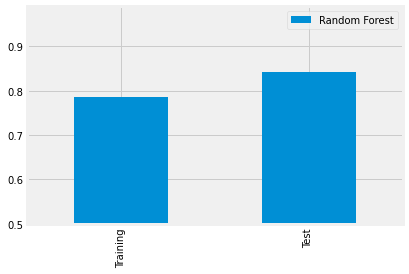

In [72]:
Random_Forest = RandomForestClassifier(random_state=42,n_estimators=300,criterion='gini',max_features='auto',min_samples_split=4,max_depth=6) 
cv_scores, test_scores = cv_classification(X_train, X_test, y_train, y_test,Random_Forest,verbose=True)
plot_compare(Classification_results,'Random Forest',cv_scores,test_scores)
Final_Scores.loc[len(Final_Scores)+1] = ['Random Forest', cv_scores, test_scores]

In [84]:
predicted = pd.DataFrame(Random_Forest.predict(X_test))  
probs = pd.DataFrame(Random_Forest.predict_proba(X_test))

In [74]:
print(classification_report(y_test, Random_Forest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91     20264
           1       0.86      0.38      0.53      6130

    accuracy                           0.84     26394
   macro avg       0.85      0.68      0.72     26394
weighted avg       0.85      0.84      0.82     26394



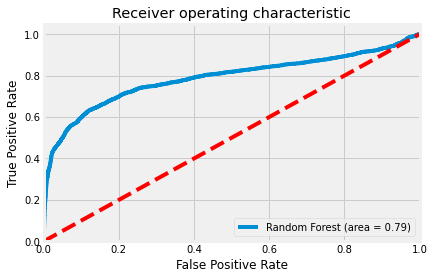

In [75]:
rf_roc_auc = roc_auc_score(y_test, Random_Forest.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, Random_Forest.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig("../Figures/BestROC_AUC_RF_REG.png",transparent=True,bbox_inches="tight")
#plt.savefig('Log_ROC')
plt.show()

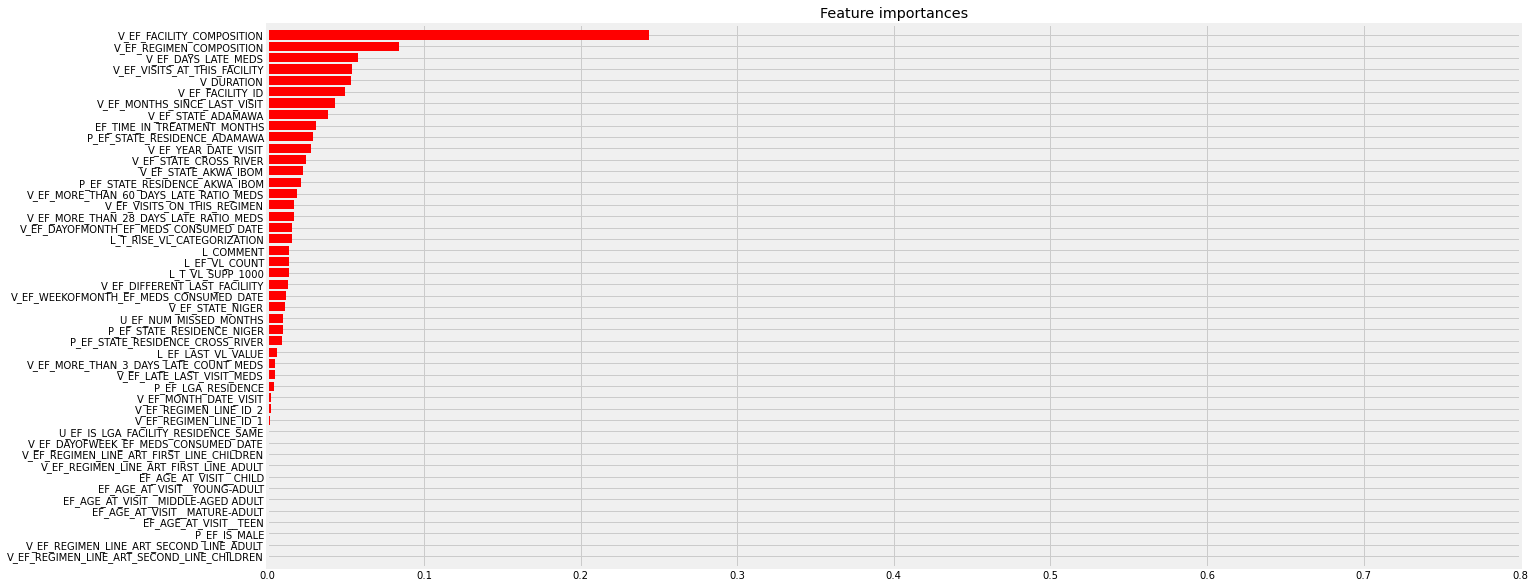

In [76]:
importance_df = features_importance(Random_Forest,  X_test)

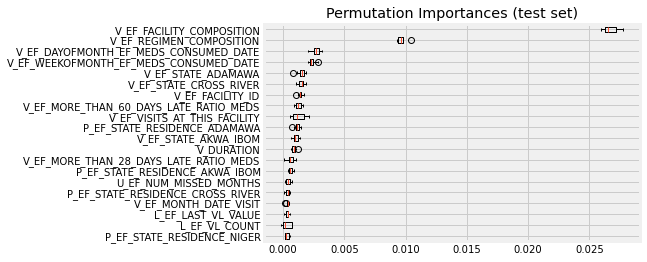

<Figure size 1440x1440 with 0 Axes>

In [77]:
from sklearn.inspection import permutation_importance
result = permutation_importance(Random_Forest, X_test, y_test, n_repeats=10,
                                    random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

end = len(sorted_idx)
start = 0
if end >20:
    start=end-20

    fig, ax = plt.subplots()
    plt.figure(figsize=(20,20))
    ax.boxplot(result.importances[sorted_idx[start:end]].T,
               vert=False, labels=X_test.columns[sorted_idx[start:end]])
    ax.set_title("Permutation Importances (test set)")
    plt.show()

In [78]:
top_features = X_train.columns[sorted_idx[start:end]].tolist()

In [79]:
top_features

['P_EF_STATE_RESIDENCE_NIGER',
 'L_EF_VL_COUNT',
 'L_EF_LAST_VL_VALUE',
 'V_EF_MONTH_DATE_VISIT',
 'P_EF_STATE_RESIDENCE_CROSS_RIVER',
 'U_EF_NUM_MISSED_MONTHS',
 'P_EF_STATE_RESIDENCE_AKWA_IBOM',
 'V_EF_MORE_THAN_28_DAYS_LATE_RATIO_MEDS',
 'V_DURATION',
 'V_EF_STATE_AKWA_IBOM',
 'P_EF_STATE_RESIDENCE_ADAMAWA',
 'V_EF_VISITS_AT_THIS_FACILITY',
 'V_EF_MORE_THAN_60_DAYS_LATE_RATIO_MEDS',
 'V_EF_FACILITY_ID',
 'V_EF_STATE_CROSS_RIVER',
 'V_EF_STATE_ADAMAWA',
 'V_EF_WEEKOFMONTH_EF_MEDS_CONSUMED_DATE',
 'V_EF_DAYOFMONTH_EF_MEDS_CONSUMED_DATE',
 'V_EF_REGIMEN_COMPOSITION',
 'V_EF_FACILITY_COMPOSITION']

    Importance                                     Feature
0       0.2438                   V_EF_FACILITY_COMPOSITION
1       0.0842                    V_EF_REGIMEN_COMPOSITION
2       0.0580                         V_EF_DAYS_LATE_MEDS
3       0.0540                V_EF_VISITS_AT_THIS_FACILITY
4       0.0530                                  V_DURATION
5       0.0493                            V_EF_FACILITY_ID
6       0.0430                V_EF_MONTHS_SINCE_LAST_VISIT
7       0.0387                          V_EF_STATE_ADAMAWA
8       0.0312                 EF_TIME_IN_TREATMENT_MONTHS
9       0.0293                P_EF_STATE_RESIDENCE_ADAMAWA
10      0.0276                        V_EF_YEAR_DATE_VISIT
11      0.0247                      V_EF_STATE_CROSS_RIVER
12      0.0230                        V_EF_STATE_AKWA_IBOM
13      0.0213              P_EF_STATE_RESIDENCE_AKWA_IBOM
14      0.0189      V_EF_MORE_THAN_60_DAYS_LATE_RATIO_MEDS
15      0.0173                 V_EF_VISITS_ON_THIS_REGIM

<AxesSubplot:ylabel='Feature'>

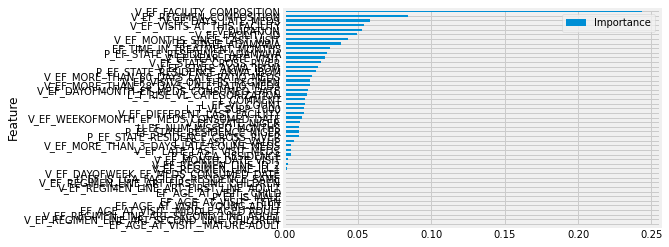

In [80]:
fi = sorted(zip(map(lambda x: round(x, 4), Random_Forest.feature_importances_), X_train)
             , reverse=True)
fi = pd.DataFrame(fi, columns = ['Importance', 'Feature'])
print(fi)
fi.sort_values(by='Importance',ascending=True).plot(kind='barh',x='Feature')

In [81]:
pm = pd.Series(result.importances_mean[sorted_idx]).rename('Permuation_Mean')
labels = pd.Series(X_train.columns[sorted_idx]).rename('Feature')
labels = labels.astype('str')
pm_table = pd.DataFrame(labels).join(pm).sort_values(by='Permuation_Mean',ascending =False)
pm_table.reset_index(drop=True, inplace=True)
pm_table.reset_index(inplace=True)
pm_table['Permuation_Mean'] = pm_table['Permuation_Mean'].round(4)

pm_table = pm_table.merge(fi.reset_index(),left_on='Feature',right_on='Feature',suffixes=('_Permutation', '_FI'))
pm_table['perm_position_delta'] = pm_table['index_FI']-pm_table['index_Permutation']



display(pm_table.style.bar(subset=['perm_position_delta'], align='mid', color=['#d65f5f', '#5fba7d']))

In [90]:
def augment_list_of_predictions(probs, raw_df, x_test,y_test, RISK_COL='',ID_FIELD='',DATE_FIELD=''):
    plist = probs.join(x_test.join(y_test).reset_index())
    plist.drop(['index',0],axis=1,inplace=True)
    if(RISK_COL!=''):
        plist = plist.rename(columns={1: RISK_COL})
    if(ID_FIELD!=''):
        plist[ID_FIELD] = raw_df[ID_FIELD]
    if(DATE_FIELD!=''):
        plist[DATE_FIELD] = raw_df[DATE_FIELD]
    return plist

% depth 0.01 % pos 0.04 gain= 0.03 3.1 X
% depth 0.05 % pos 0.2 gain= 0.15 3.0 X
% depth 0.1 % pos 0.37 gain= 0.27 2.7 X
% depth 0.15 % pos 0.49 gain= 0.34 2.3 X
% depth 0.2 % pos 0.57 gain= 0.37 1.9 X
% depth 0.25 % pos 0.64 gain= 0.39 1.6 X
% depth 0.4001 % pos 0.75 gain= 0.35 0.9 X
% depth 0.6 % pos 0.83 gain= 0.23 0.4 X
% depth 0.8 % pos 0.88 gain= 0.08 0.1 X


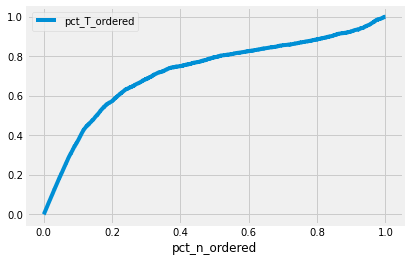

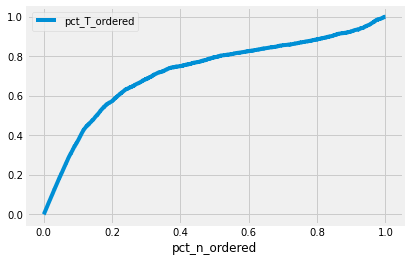

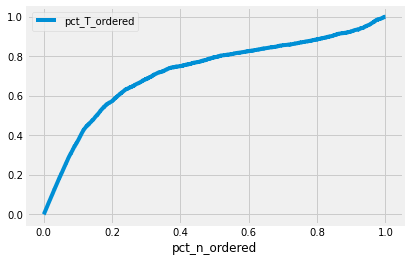

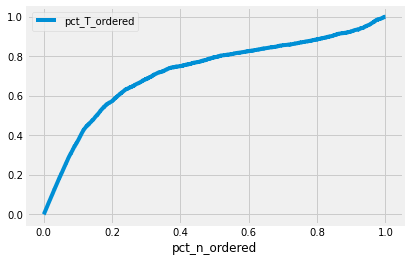

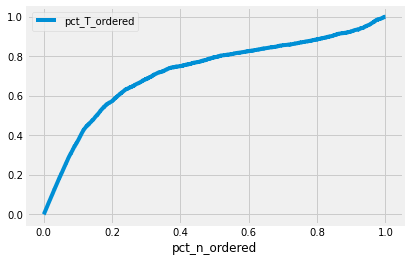

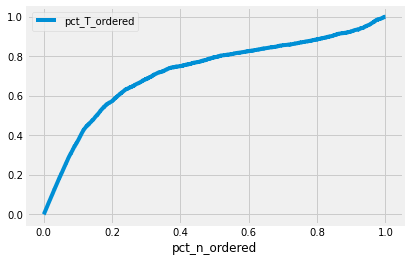

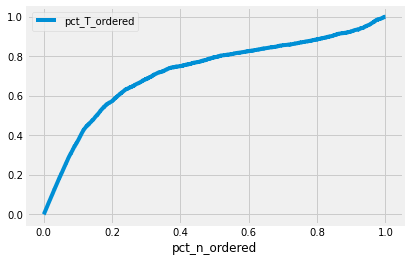

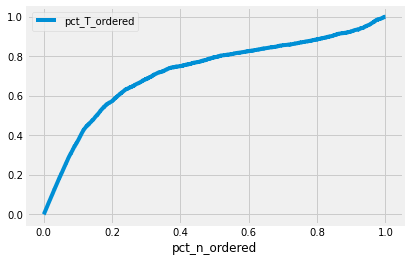

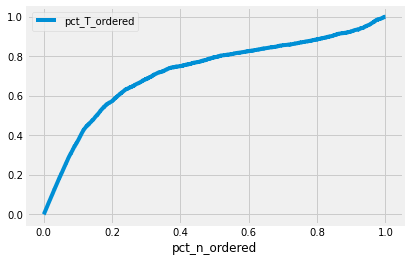

In [92]:
plist = augment_list_of_predictions(probs,test, X_test,y_test, 'risk_score')
# 
plist = plist.sort_values(by='risk_score',ascending=False)
plist['n_ordered'] = range(1,len(plist)+1)
plist['cumsum_T_ordered'] = plist['V_T_MISSED_NEXT_VISIT_28_RISE'].cumsum()

plist['pct_n_ordered'] = (plist['n_ordered'] /len(plist)).round(decimals=4)
plist['pct_T_ordered'] = (plist['cumsum_T_ordered']/plist['V_T_MISSED_NEXT_VISIT_28_RISE'].sum()).round(decimals=4)
plist['pct_gain'] = (plist['pct_T_ordered'] - plist['pct_n_ordered'])
plist['X'] = round(plist['pct_gain']/plist['pct_n_ordered'],1)

# generate depth of file
z = plist[['risk_score','V_T_MISSED_NEXT_VISIT_28_RISE', 'cumsum_T_ordered','n_ordered','pct_n_ordered', 'pct_T_ordered','pct_gain','X']]
z = z.reset_index()
for pct in [0.01,0.05,0.1,0.15,0.2,0.25,0.4,0.6,0.8]:
    n = round(len(z)*pct)
    print("% depth",z.loc[n,'pct_n_ordered'], "% pos",z.loc[n,'pct_T_ordered'].round(decimals=2),
          "gain=",z.loc[n,'pct_gain'].round(decimals=2),z.loc[n,'X'],'X')
    z[['pct_n_ordered','pct_T_ordered']].plot(x='pct_n_ordered',y='pct_T_ordered')

In [93]:
plist_df = plist_manager.plist_add_risk_groups(plist)

In [101]:
group_list = ['risk_bin_quarts','risk_bin_manual','risk_bin_thirds','risk_bin_pareto']
for g in group_list:
    t = plist_manager.riskgroup_target_share_table(plist_df,g,'V_T_MISSED_NEXT_VISIT_28_RISE')
    display(t)

risk_bin_quarts  risk_bin_quarts_pct  risk_bin_quarts_pct_targetED  \
1            13199                 0.50                          0.20   
2             6596                 0.25                          0.15   
3             6599                 0.25                          0.64   

   _pos_pct  
1      0.10  
2      0.14  
3      0.60

risk_bin_manual  risk_bin_manual_pct  risk_bin_manual_pct_targetED  \
Green             13199                 0.50                          0.20   
Yellow             9235                 0.35                          0.30   
Red                3960                 0.15                          0.49   

        _pos_pct  
Green       0.10  
Yellow      0.20  
Red         0.76

risk_bin_thirds  risk_bin_thirds_pct  risk_bin_thirds_pct_targetED  \
1             8976                 0.34                          0.16   
2             8707                 0.33                          0.13   
3             8711                 0.33                          0.71   

   _pos_pct  
1      0.11  
2      0.09  
3      0.50

risk_bin_pareto  risk_bin_pareto_pct  risk_bin_pareto_pct_targetED  \
1            13199                  0.5                          0.20   
2            10555                  0.4                          0.42   
3             2640                  0.1                          0.37   

   _pos_pct  
1      0.10  
2      0.24  
3      0.87

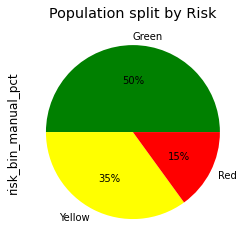

In [102]:
t = plist_manager.riskgroup_target_share_table(plist_df,'risk_bin_manual','V_T_MISSED_NEXT_VISIT_28_RISE')
t.risk_bin_manual_pct.plot.pie(autopct = "%.0f%%", colors = ['green', 'yellow','red'] )
plt.title('Population split by Risk')
plt.show()

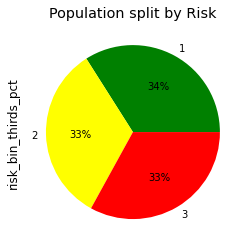

In [103]:
t1 = plist_manager.riskgroup_target_share_table(plist_df,'risk_bin_thirds','V_T_MISSED_NEXT_VISIT_28_RISE')
t1.risk_bin_thirds_pct.plot.pie(autopct = "%.0f%%", colors = ['green', 'yellow','red'] )
plt.title('Population split by Risk')
plt.show()

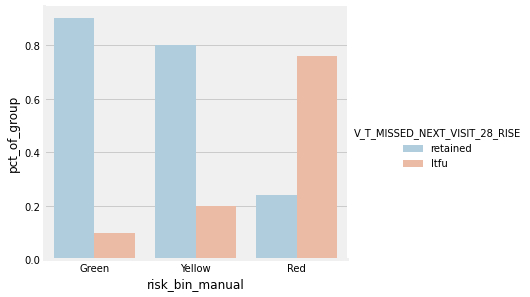

In [100]:
plist_manager.plot_riskgroup_by_target(plist.copy(), 'risk_bin_manual', 'V_T_MISSED_NEXT_VISIT_28_RISE')